In [1]:
import os
import numpy as np 
import pandas as pd 

from merf import MERF
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

from merf.viz import plot_merf_training_stats
from sklearn.inspection import plot_partial_dependence
# import shap
import math

import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [2]:
# read in data
dswe = pd.read_csv('../data/all_data_0018.csv', index_col=0)

dswe.head()


,HUC08,SEASON,YEAR,PR_WATER,MAX_TMP,MIN_TMP,PRECIP,PR_AG,PR_INT,PR_NAT,PR_POP
0,3150106,Fall,2000,0.017054,0.065982,0.079972,0.002974,0.016109,0.105469,0.855719,48.657514
1,3160107,Fall,2000,0.001736,-0.043130,0.046309,0.034296,0.007119,0.043102,0.944771,8.825433
2,3160203,Fall,2000,0.006706,0.038589,0.085311,0.019101,0.002354,0.033000,0.954051,8.959161
3,3150203,Fall,2000,0.013039,0.034896,0.083323,0.023734,0.019356,0.028915,0.932121,5.552092
4,3150204,Fall,2000,0.007564,0.044560,0.094443,0.009426,0.032437,0.029343,0.926452,6.884218


In [3]:
dswe['MAX_TMP'] = dswe['MAX_TMP'] * -1
dswe['MIN_TMP'] = dswe['MIN_TMP'] * -1
dswe['PRECIP'] = dswe['PRECIP'] * -1

In [4]:
dswe.groupby(['YEAR']).mean()

,HUC08,PR_WATER,MAX_TMP,MIN_TMP,PRECIP,PR_AG,PR_INT,PR_NAT,PR_POP
YEAR,,,,,,,,,
2000,4.231679e+06,0.063090,-0.022629,-0.147238,-0.077398,0.096816,0.087628,0.748642,49.846980
2001,4.231679e+06,0.064069,-0.045053,-0.053486,-0.021341,0.096816,0.087628,0.748642,49.799905
2002,4.231679e+06,0.064509,-0.092215,0.017089,0.026023,0.096835,0.088375,0.747810,51.157165
2003,4.231679e+06,0.064728,-0.182543,0.010549,0.062547,0.096854,0.089122,0.746978,51.698076
2004,4.231679e+06,0.065443,-0.079558,0.083043,0.016322,0.096872,0.089869,0.746146,52.442615
2005,4.231679e+06,0.063632,-0.060897,0.041063,0.000533,0.096891,0.090616,0.745314,53.348636
2006,4.231679e+06,0.062995,0.045743,-0.026181,-0.053657,0.096910,0.091362,0.744483,54.185178
2007,4.231679e+06,0.062781,0.172295,0.053431,-0.095784,0.097029,0.090097,0.745868,54.927044
2008,4.231679e+06,0.064896,-0.079816,-0.094425,-0.034284,0.097148,0.088832,0.747254,55.445028


In [5]:
import random

In [6]:
hucs = dswe["HUC08"].unique()
hucs[0]

3150106

## SKIP THESE NEXT CELLS

In [ ]:
fall_df = pd.DataFrame({"HUC08":0, "SEASON":"Fall", "YEAR":0}, index=list(range(0,25420)))

fall_df["YEAR"] = np.sort(np.tile(np.array(list(range(2019,2101))),310))
fall_df["HUC08"] = np.tile(np.array(hucs), 82)

spring_df = pd.DataFrame({"HUC08":0, "SEASON":"Spring", "YEAR":0}, index=list(range(0,25420)))

spring_df["YEAR"] = np.sort(np.tile(np.array(list(range(2019,2101))),310))
spring_df["HUC08"] = np.tile(np.array(hucs), 82)

summer_df = pd.DataFrame({"HUC08":0, "SEASON":"Summer", "YEAR":0}, index=list(range(0,25420)))

summer_df["YEAR"] = np.sort(np.tile(np.array(list(range(2019,2101))),310))
summer_df["HUC08"] = np.tile(np.array(hucs), 82)

winter_df = pd.DataFrame({"HUC08":0, "SEASON":"Winter", "YEAR":0}, index=list(range(0,25420)))

winter_df["YEAR"] = np.sort(np.tile(np.array(list(range(2019,2101))),310))
winter_df["HUC08"] = np.tile(np.array(hucs), 82)

full_df = pd.concat([fall_df,spring_df])
full_df = pd.concat([full_df,summer_df])
full_df = pd.concat([full_df,winter_df])

full_df

In [ ]:
mxtp_slope = 0.0092
prp_slope = 0.004
pr_ag_slope = 0.0002
pr_int_slope = 0.0002
pr_nat_slope = -0.0005

In [ ]:
def add_random(gp_tmp, col_name):

    gp_mean = gp_tmp[col_name].mean()
    gp_std = gp_tmp[col_name].std()

    return (np.random.normal(gp_mean, gp_std))

In [ ]:
sim_future.append([[0,0,0, 0,0, 0,0,0]] * 1240)

In [ ]:
sim_future = [[0,0,0, 0,0, 0,0,0]] * 125240
gp = dswe.groupby(['HUC08', 'SEASON'])

for i in range(125240):
    if i < 23560:
        temp_arr = list(dswe.iloc[i][0:3])
        gp_tmp = gp.get_group((temp_arr[0],temp_arr[1]))
        
        mxt = dswe.iloc[i][4] + add_random(gp_tmp, ['MAX_TMP']) / 100
        temp_arr.append(mxt[0])

        prp = dswe.iloc[i][6] + add_random(gp_tmp, ['PRECIP']) / 100
        temp_arr.append(prp[0])

        
        ag = dswe.iloc[i][7] + add_random(gp_tmp, ['PR_AG']) / 100
        temp_arr.append(ag[0])

        intsive = dswe.iloc[i][8] + add_random(gp_tmp, ['PR_INT']) / 100
        temp_arr.append(intsive[0])

        natural = dswe.iloc[i][9] + add_random(gp_tmp, ['PR_NAT']) / 100
        temp_arr.append(natural[0])

        # print(temp_arr)
        # sim_future[i] = temp_arr
    else:
        if i-23560 == 0:
            yr = 19
        temp_arr = list(full_df.iloc[i-23560][0:3])
        gp_tmp = gp.get_group((temp_arr[0],temp_arr[1]))

        mxt = yr * mxtp_slope + add_random(gp_tmp, ['MAX_TMP']) 
        temp_arr.append(mxt[0])

        prp = yr * prp_slope + add_random(gp_tmp, ['PRECIP']) 
        temp_arr.append(prp[0])

        
        ag = yr * pr_ag_slope + add_random(gp_tmp, ['PR_AG']) 
        temp_arr.append(ag[0])

        intsive = yr * pr_int_slope + add_random(gp_tmp, ['PR_INT']) 
        temp_arr.append(intsive[0])

        natural = yr * pr_nat_slope + add_random(gp_tmp, ['PR_NAT']) 
        temp_arr.append(natural[0])

        yr += 1

        # if i-23560 == 0:
        #     mxt = float(gp_tmp[gp_tmp["YEAR"]==2018].MAX_TMP) * mxtp_slope + add_random(gp_tmp, ['MAX_TMP']) 
        #     temp_arr.append(mxt[0])

        #     prp = float(gp_tmp[gp_tmp["YEAR"]==2018].PRECIP) * prp_slope + add_random(gp_tmp, ['PRECIP']) 
        #     temp_arr.append(prp[0])

            
        #     ag = float(gp_tmp[gp_tmp["YEAR"]==2018].PR_AG) * pr_ag_slope + add_random(gp_tmp, ['PR_AG']) 
        #     temp_arr.append(ag[0])

        #     intsive = float(gp_tmp[gp_tmp["YEAR"]==2018].PR_INT) * pr_int_slope + add_random(gp_tmp, ['PR_INT']) 
        #     temp_arr.append(intsive[0])

        #     natural = float(gp_tmp[gp_tmp["YEAR"]==2018].PR_NAT) * pr_nat_slope + add_random(gp_tmp, ['PR_NAT']) 
        #     temp_arr.append(natural[0])

        # else:
        #     mxt = sim_future[i-1][3] * mxtp_slope + add_random(gp_tmp, ['MAX_TMP']) 
        #     temp_arr.append(mxt[0])

        #     prp = sim_future[i-1][4] * prp_slope + add_random(gp_tmp, ['PRECIP']) 
        #     temp_arr.append(prp[0])

            
        #     ag = sim_future[i-1][5] * pr_ag_slope + add_random(gp_tmp, ['PR_AG']) 
        #     temp_arr.append(ag[0])

        #     intsive = sim_future[i-1][6] * pr_int_slope + add_random(gp_tmp, ['PR_INT']) 
        #     temp_arr.append(intsive[0])

        #     natural = sim_future[i-1][7] * pr_nat_slope + add_random(gp_tmp, ['PR_NAT']) 
        #     temp_arr.append(natural[0])

        # print(temp_arr)
    sim_future[i] = temp_arr



        



In [ ]:
while len(sim_future) < 125240:
    sim_future.append([0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
sim_future[-1]

In [ ]:
df = pd.DataFrame(sim_future, columns = ['HUC08','SEASON','YEAR','MAX_TMP','PRECIP','PR_AG','PR_INT','PR_NAT'])
df

In [ ]:
df.to_csv('../data/sim_future.csv')

In [ ]:
sim_dswe = pd.read_csv('../data/sim_future.csv')

In [ ]:
sim_dswe.head()

### DO NOT RUN THIS CELL

In [ ]:
# log transform dswe water data
dswe['LOG_PR_WATER'] = np.log(dswe['PR_WATER'] + 10e-6)

# center and standardize independent variables
dswe['MAX_TMP'] = (dswe['MAX_TMP'] - np.mean(dswe['MAX_TMP'])) / np.std(dswe['MAX_TMP'])
dswe['PRECIP'] = (dswe['PRECIP'] - np.mean(dswe['PRECIP'])) / np.std(dswe['PRECIP'])

dswe['PR_AG'] = (dswe['PR_AG'] - np.mean(dswe['PR_AG'])) / np.std(dswe['PR_AG'])
dswe['PR_NAT'] = (dswe['PR_NAT'] - np.mean(dswe['PR_NAT'])) / np.std(dswe['PR_NAT'])
dswe['PR_INT'] = (dswe['PR_INT'] - np.mean(dswe['PR_INT'])) / np.std(dswe['PR_INT'])

# # same for future data
# sim_dswe['MAX_TMP'] = (sim_dswe['MAX_TMP'] - np.mean(sim_dswe['MAX_TMP'])) / np.std(sim_dswe['MAX_TMP'])
# sim_dswe['PRECIP'] = (sim_dswe['PRECIP'] - np.mean(sim_dswe['PRECIP'])) / np.std(sim_dswe['PRECIP'])

# sim_dswe['PR_AG'] = (sim_dswe['PR_AG'] - np.mean(sim_dswe['PR_AG'])) / np.std(sim_dswe['PR_AG'])
# sim_dswe['PR_NAT'] = (sim_dswe['PR_NAT'] - np.mean(sim_dswe['PR_NAT'])) / np.std(sim_dswe['PR_NAT'])
# sim_dswe['PR_INT'] = (sim_dswe['PR_INT'] - np.mean(sim_dswe['PR_INT'])) / np.std(sim_dswe['PR_INT'])


### RUN THESE

In [7]:
# read in data
dswe_future_a1b85 = pd.read_csv('../data/FutureData/2006_2099_A1B_FORESCE_RCP85_GFDLESM2M.csv', index_col=0)

dswe_future_a1b85.head()

,huc8,YEAR,PR_AG,PR_NAT,PR_INT,SEASON,PRECIP_ANOM,TEMP_ANOM
0,8030100,2006,0.060172,0.622792,0.040663,SPRING,-0.138164,0.065911
1,8020100,2006,0.227800,0.517675,0.030550,SPRING,-0.121977,0.098981
2,8060206,2006,0.034456,0.911092,0.037778,SPRING,-0.163704,0.079208
3,8060205,2006,0.045390,0.911968,0.035589,SPRING,-0.161450,0.047605
4,3180003,2006,0.042767,0.894587,0.050093,SPRING,-0.175451,0.067310


<AxesSubplot:>

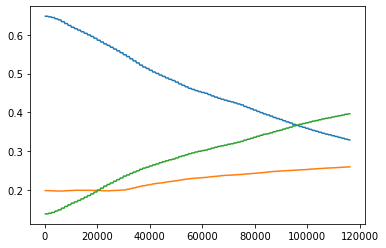

In [9]:
dswe_future_a1b85 = dswe_future_a1b85.reset_index()
dswe_future_a1b85[dswe_future_a1b85['huc8']==3020201]['PR_NAT'].plot()
dswe_future_a1b85[dswe_future_a1b85['huc8']==3020201]['PR_AG'].plot()
dswe_future_a1b85[dswe_future_a1b85['huc8']==3020201]['PR_INT'].plot()


<AxesSubplot:>

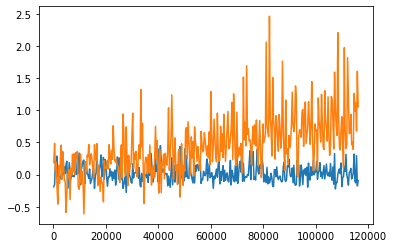

In [10]:
dswe_future_a1b85[dswe_future_a1b85['huc8']==3020201]['PRECIP_ANOM'].plot()
dswe_future_a1b85[dswe_future_a1b85['huc8']==3020201]['TEMP_ANOM'].plot()

(array([ 11.,  25.,  72., 126., 208., 246., 172.,  91.,  36.,  13.]),
 array([-0.28806218, -0.23118384, -0.17430551, -0.11742717, -0.06054884,
        -0.0036705 ,  0.05320784,  0.11008617,  0.16696451,  0.22384284,
         0.28072118]),
 <BarContainer object of 10 artists>)

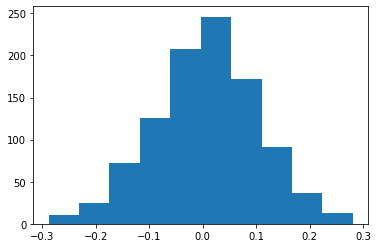

In [11]:
lst = [0]*1000
for i in range(1000):
    lst[i] = np.random.normal(0.0, 0.1)

plt.hist(lst)
# dswe_future_a1b85[dswe_future_a1b85['huc8']==3020201]['TEMP_ANOM'].hist()
    

In [12]:
# read in data
dswe_future_b245 = pd.read_csv('../data/FutureData/2006_2099_B2_FORESCE_RCP45_GFDLESM2M.csv', index_col=0)

dswe_future_b245.head()

,huc8,YEAR,PR_AG,PR_NAT,PR_INT,SEASON,PRECIP_ANOM,TEMP_ANOM
0,8030100,2006,0.060252,0.622551,0.040864,SPRING,0.099602,0.111413
1,8020100,2006,0.228613,0.517349,0.030509,SPRING,-0.028588,0.149868
2,8060206,2006,0.034781,0.906207,0.042337,SPRING,0.703164,0.169147
3,8060205,2006,0.045754,0.905279,0.041914,SPRING,0.487595,0.134426
4,3180003,2006,0.043718,0.885855,0.057894,SPRING,0.288164,0.135714


In [34]:
# # same for future data
# dswe_future_a1b85['MAX_TMP'] = (dswe_future_a1b85['TEMP_ANOM'] - np.mean(dswe_future_a1b85['TEMP_ANOM'])) / np.std(dswe_future_a1b85['TEMP_ANOM'])
# dswe_future_a1b85['PRECIP'] = (dswe_future_a1b85['PRECIP_ANOM'] - np.mean(dswe_future_a1b85['PRECIP_ANOM'])) / np.std(dswe_future_a1b85['PRECIP_ANOM'])

dswe_future_a1b85['MAX_TMP'] = dswe_future_a1b85['TEMP_ANOM'] 
dswe_future_a1b85['PRECIP'] = dswe_future_a1b85['PRECIP_ANOM'] 

# dswe_future_a1b85['PR_AG'] = (dswe_future_a1b85['PR_AG'] - np.mean(dswe_future_a1b85['PR_AG'])) / np.std(dswe_future_a1b85['PR_AG'])
# dswe_future_a1b85['PR_NAT'] = (dswe_future_a1b85['PR_NAT'] - np.mean(dswe_future_a1b85['PR_NAT'])) / np.std(dswe_future_a1b85['PR_NAT'])
# dswe_future_a1b85['PR_INT'] = (dswe_future_a1b85['PR_INT'] - np.mean(dswe_future_a1b85['PR_INT'])) / np.std(dswe_future_a1b85['PR_INT'])

# dswe_future_a1b85.head()

In [35]:
# # same for future data
# dswe_future_b245['MAX_TMP'] = (dswe_future_b245['TEMP_ANOM'] - np.mean(dswe_future_b245['TEMP_ANOM'])) / np.std(dswe_future_b245['TEMP_ANOM'])
# dswe_future_b245['PRECIP'] = (dswe_future_b245['PRECIP_ANOM'] - np.mean(dswe_future_b245['PRECIP_ANOM'])) / np.std(dswe_future_b245['PRECIP_ANOM'])

dswe_future_b245['MAX_TMP'] = dswe_future_b245['TEMP_ANOM']
dswe_future_b245['PRECIP'] = dswe_future_b245['PRECIP_ANOM'] 

# dswe_future_b245['PR_AG'] = (dswe_future_b245['PR_AG'] - np.mean(dswe_future_b245['PR_AG'])) / np.std(dswe_future_b245['PR_AG'])
# dswe_future_b245['PR_NAT'] = (dswe_future_b245['PR_NAT'] - np.mean(dswe_future_b245['PR_NAT'])) / np.std(dswe_future_b245['PR_NAT'])
# dswe_future_b245['PR_INT'] = (dswe_future_b245['PR_INT'] - np.mean(dswe_future_b245['PR_INT'])) / np.std(dswe_future_b245['PR_INT'])

# dswe_future_b245.head()

In [15]:
# create HUC_SEASON cluster id
dswe['HUC_SEASON'] = dswe['HUC08'].astype('str') + '_' + dswe['SEASON']
dswe.head()

,HUC08,SEASON,YEAR,PR_WATER,MAX_TMP,MIN_TMP,PRECIP,PR_AG,PR_INT,PR_NAT,PR_POP,HUC_SEASON
0,3150106,Fall,2000,0.017054,-0.065982,-0.079972,-0.002974,0.016109,0.105469,0.855719,48.657514,3150106_Fall
1,3160107,Fall,2000,0.001736,0.043130,-0.046309,-0.034296,0.007119,0.043102,0.944771,8.825433,3160107_Fall
2,3160203,Fall,2000,0.006706,-0.038589,-0.085311,-0.019101,0.002354,0.033000,0.954051,8.959161,3160203_Fall
3,3150203,Fall,2000,0.013039,-0.034896,-0.083323,-0.023734,0.019356,0.028915,0.932121,5.552092,3150203_Fall
4,3150204,Fall,2000,0.007564,-0.044560,-0.094443,-0.009426,0.032437,0.029343,0.926452,6.884218,3150204_Fall


In [38]:
dswe_future_a1b85['HUC_SEASON'] = dswe_future_a1b85['huc8'].astype('str') + '_' + dswe_future_a1b85['SEASON']
dswe_future_a1b85.head()

,huc8,YEAR,PR_AG,PR_NAT,PR_INT,SEASON,PRECIP_ANOM,TEMP_ANOM,MAX_TMP,PRECIP,HUC_SEASON
0,8030100,2006,0.060172,0.622792,0.040663,SPRING,-0.138164,0.065911,0.065911,-0.138164,8030100_SPRING
1,8020100,2006,0.227800,0.517675,0.030550,SPRING,-0.121977,0.098981,0.098981,-0.121977,8020100_SPRING
2,8060206,2006,0.034456,0.911092,0.037778,SPRING,-0.163704,0.079208,0.079208,-0.163704,8060206_SPRING
3,8060205,2006,0.045390,0.911968,0.035589,SPRING,-0.161450,0.047605,0.047605,-0.161450,8060205_SPRING
4,3180003,2006,0.042767,0.894587,0.050093,SPRING,-0.175451,0.067310,0.067310,-0.175451,3180003_SPRING


In [39]:
dswe_future_b245['HUC_SEASON'] = dswe_future_b245['huc8'].astype('str') + '_' + dswe_future_b245['SEASON']
dswe_future_b245.head()

,huc8,YEAR,PR_AG,PR_NAT,PR_INT,SEASON,PRECIP_ANOM,TEMP_ANOM,MAX_TMP,PRECIP,HUC_SEASON
0,8030100,2006,0.060252,0.622551,0.040864,SPRING,0.099602,0.111413,0.111413,0.099602,8030100_SPRING
1,8020100,2006,0.228613,0.517349,0.030509,SPRING,-0.028588,0.149868,0.149868,-0.028588,8020100_SPRING
2,8060206,2006,0.034781,0.906207,0.042337,SPRING,0.703164,0.169147,0.169147,0.703164,8060206_SPRING
3,8060205,2006,0.045754,0.905279,0.041914,SPRING,0.487595,0.134426,0.134426,0.487595,8060205_SPRING
4,3180003,2006,0.043718,0.885855,0.057894,SPRING,0.288164,0.135714,0.135714,0.288164,3180003_SPRING


In [ ]:
# sim_dswe['HUC_SEASON'] = sim_dswe['HUC08'].astype('str') + '_' + sim_dswe['SEASON']
# sim_dswe.head()

In [20]:
dswe = dswe.rename(columns={"PR_WATER": "LOG_PR_WATER"})

train, test = train_test_split(dswe, test_size=0.2, shuffle=True)

In [21]:
rf_fe_b = RandomForestRegressor(n_estimators = 1000, random_state = 42)

mrf_both2 = MERF(rf_fe_b, max_iterations=200)
X_train_both2 = train[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
Z_train_both2 = np.ones((len(X_train_both2), 1))
clusters_train_both2 = train['HUC_SEASON']
y_train_both2 = train['LOG_PR_WATER']
mrf_both2.fit(X_train_both2, Z_train_both2, clusters_train_both2, y_train_both2)


INFO     [merf.py:307] Training GLL is -55934.26276332763 at iteration 1.
INFO     [merf.py:307] Training GLL is -111702.07112594869 at iteration 2.
INFO     [merf.py:307] Training GLL is -164881.17108637307 at iteration 3.
INFO     [merf.py:307] Training GLL is -196307.4301455465 at iteration 4.
INFO     [merf.py:307] Training GLL is -199383.24154441943 at iteration 5.
INFO     [merf.py:307] Training GLL is -199442.22694883932 at iteration 6.
INFO     [merf.py:307] Training GLL is -199305.1665758862 at iteration 7.
INFO     [merf.py:307] Training GLL is -199311.68636903632 at iteration 8.
INFO     [merf.py:307] Training GLL is -199339.83725018663 at iteration 9.
INFO     [merf.py:307] Training GLL is -199366.63044080217 at iteration 10.
INFO     [merf.py:307] Training GLL is -199331.5349533395 at iteration 11.
INFO     [merf.py:307] Training GLL is -199437.56358666677 at iteration 12.
INFO     [merf.py:307] Training GLL is -199474.52962257547 at iteration 13.
INFO     [merf.py:307] Tr

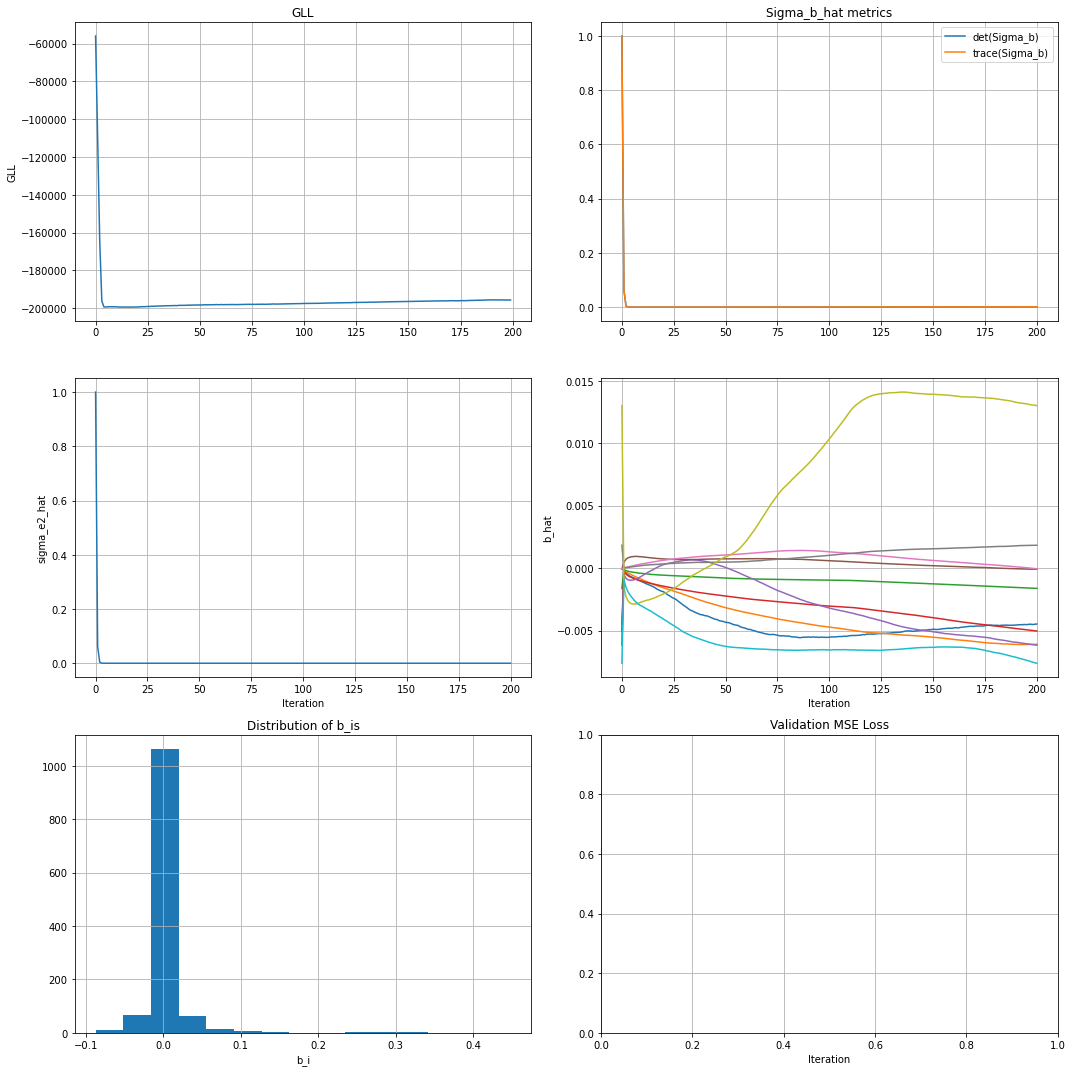

In [22]:
plot_merf_training_stats(mrf_both2, num_clusters_to_plot=10)


In [ ]:
# X_test_both2 = test[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
# Z_test_both2 = np.ones((len(X_test_both2), 1))
# clusters_test_both2 = test['HUC_SEASON']
# y_test_both2 = test['LOG_PR_WATER']

In [ ]:
# y_hat_bothh2 = mrf_both2.predict(X_test_both2, Z_test_both2, clusters_test_both2)
# y_hat_bot2

In [23]:
y_hat_full_both2 = mrf_both2.predict(dswe[['PRECIP', 'MAX_TMP','PR_AG', 'PR_INT', 'PR_NAT']], np.ones((len(dswe[['PRECIP', 'MAX_TMP','PR_AG', 'PR_INT', 'PR_NAT']]), 1)), dswe['HUC_SEASON'])
y_hat_full_both2

array([0.01726915, 0.00241868, 0.00682335, ..., 0.01120334, 0.01516897,
       0.38441664])

### SKIP THESE CELLS

In [ ]:
X_future = sim_dswe[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
Z_future = np.ones((len(X_future), 1))
clusters_future = sim_dswe['HUC_SEASON']


In [36]:
dswe_future_a1b85[dswe_future_a1b85['huc8']==3020201]

,huc8,YEAR,PR_AG,PR_NAT,PR_INT,SEASON,PRECIP_ANOM,TEMP_ANOM,MAX_TMP,PRECIP
192,3020201,2006,0.197980,0.647698,0.137886,SPRING,-0.190716,0.187414,0.187414,-0.190716
192,3020201,2006,0.197980,0.647698,0.137886,SUMMER,-0.152338,0.486765,0.486765,-0.152338
192,3020201,2006,0.197980,0.647698,0.137886,FALL,0.190203,0.062623,0.062623,0.190203
192,3020201,2006,0.197980,0.647698,0.137886,WINTER,0.137761,0.192919,0.192919,0.137761
192,3020201,2007,0.197830,0.646154,0.139521,SPRING,0.287414,-0.211149,-0.211149,0.287414
...,...,...,...,...,...,...,...,...,...,...
192,3020201,2098,0.258666,0.330753,0.394838,FALL,-0.104057,0.985487,0.985487,-0.104057
192,3020201,2098,0.258666,0.330753,0.394838,WINTER,-0.129680,1.122654,1.122654,-0.129680
192,3020201,2099,0.259198,0.329018,0.396041,SPRING,0.294705,0.676080,0.676080,0.294705
192,3020201,2099,0.259198,0.329018,0.396041,SUMMER,-0.177037,1.605722,1.605722,-0.177037


In [40]:
test = dswe_future_a1b85[dswe_future_a1b85['huc8']==3020201]
X_future = test[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
Z_future = np.ones((len(X_future), 1))
clusters_future = test['HUC_SEASON']
y_hat_test = mrf_both2.predict(X_future, Z_future, clusters_future)
y_hat_test

array([0.02234334, 0.02278067, 0.02331626, 0.02347853, 0.02423021,
       0.02266278, 0.02331462, 0.02373727, 0.02321345, 0.02309412,
       0.02359714, 0.02354646, 0.02331609, 0.02380771, 0.02360164,
       0.02421555, 0.02314556, 0.02252053, 0.02327814, 0.02318652,
       0.02287194, 0.02304365, 0.02308966, 0.02361273, 0.02321177,
       0.02353517, 0.02308201, 0.0234076 , 0.02357647, 0.0237171 ,
       0.02356898, 0.02363381, 0.02339897, 0.02322381, 0.02354682,
       0.02312424, 0.02322315, 0.02445468, 0.02318612, 0.0231974 ,
       0.01974812, 0.01847835, 0.01844475, 0.01863538, 0.01896943,
       0.01833312, 0.01852697, 0.01831803, 0.0192828 , 0.0195327 ,
       0.01877261, 0.01875837, 0.01853189, 0.02419594, 0.01893149,
       0.01847922, 0.01958789, 0.02057004, 0.02763957, 0.01884023,
       0.01941277, 0.02167721, 0.01848505, 0.02126941, 0.02106715,
       0.01930321, 0.01870985, 0.019361  , 0.0193113 , 0.02001797,
       0.01948599, 0.01987894, 0.02306312, 0.02364716, 0.02312

In [45]:
test['PRED_LOG_WATER'] = y_hat_test
test.to_csv('../pred_03020201_2006_2099_A1B_FORESCE_RCP85_GFDLESM2M.csv')

<ipython-input-45-49ce34f58916>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['PRED_LOG_WATER'] = y_hat_test


In [ ]:
df_output[df_output['HUC08']==3020201]

In [ ]:
test[test['huc8']==3020201]

In [ ]:
X_future = dswe_future_a1b85[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
Z_future = np.ones((len(X_future), 1))
clusters_future = dswe_future_a1b85['HUC_SEASON']


In [43]:
test2 = dswe_future_b245[dswe_future_b245['huc8']==3020201]
X_future2 = test2[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
Z_future2 = np.ones((len(X_future2), 1))
clusters_future2 = test2['HUC_SEASON']
y_hat_future2 = mrf_both2.predict(X_future2, Z_future2, clusters_future2)
y_hat_future2

array([0.02319311, 0.02348368, 0.0229867 , 0.02287182, 0.02328757,
       0.02318074, 0.02340597, 0.02343301, 0.02229522, 0.02348252,
       0.02333778, 0.02352425, 0.02287192, 0.02281672, 0.02309906,
       0.02335321, 0.02375249, 0.0228283 , 0.0228735 , 0.02353245,
       0.0221851 , 0.02319797, 0.02282555, 0.02307632, 0.02306534,
       0.02302888, 0.02302464, 0.02331607, 0.02348549, 0.02337336,
       0.02324826, 0.02352355, 0.02324829, 0.02278018, 0.02373656,
       0.02393339, 0.02291447, 0.02345234, 0.02324392, 0.02318802,
       0.02368527, 0.02384092, 0.02354584, 0.0234083 , 0.02372619,
       0.02335626, 0.02294516, 0.02319803, 0.02325642, 0.02335734,
       0.02341244, 0.02357961, 0.02311236, 0.02313705, 0.02311905,
       0.0230808 , 0.02312838, 0.02297051, 0.02315615, 0.02334183,
       0.02301468, 0.02335809, 0.02317622, 0.02350457, 0.02353721,
       0.02358322, 0.02319485, 0.023423  , 0.02314618, 0.02488019,
       0.02263497, 0.02318519, 0.02316171, 0.02332606, 0.02324

In [44]:
test2['PRED_LOG_WATER'] = y_hat_future2
test2.to_csv('../pred_03020201_2006_2099_B2_FORESCE_RCP45_GFDLESM2M.csv')

<ipython-input-44-2790b9936b63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['PRED_LOG_WATER'] = y_hat_future2


In [ ]:
y_hat_future = mrf_both2.predict(X_future, Z_future, clusters_future)
y_hat_future

In [ ]:
df_output = dswe_future_a1b85[['huc8','SEASON','YEAR']]
df_output['PRED_LOG_WATER'] = y_hat_future
df_output = df_output.reset_index()
df_output = df_output.rename(columns={"huc8": "HUC08"})
df_output

In [ ]:
df_output2 = dswe_future_b245[['huc8','SEASON','YEAR']]
df_output2['PRED_LOG_WATER'] = y_hat_future2
df_output2 = df_output2.reset_index()
df_output2 = df_output2.rename(columns={"huc8": "HUC08"})
df_output2

In [ ]:
dswe['SEASON'] = dswe['SEASON'].str.upper()
dswe['EST_LOG_WATER'] = y_hat_full_both2
dswe = dswe.rename(columns={"LOG_PR_WATER": "OBS_LOG_WATER"})

dswe

In [ ]:
df_output = df_output.merge(dswe[['HUC08','SEASON','YEAR','OBS_LOG_WATER','EST_LOG_WATER']], \
    left_on=['HUC08', 'SEASON', 'YEAR'], \
    right_on=['HUC08','SEASON','YEAR'],\
    how='outer')
df_output
# tmp = pd.DataFrame({'OBS_LOG_WATER':list(dswe['LOG_PR_WATER'])})

In [ ]:
df_output2 = df_output2.merge(dswe[['HUC08','SEASON','YEAR','OBS_LOG_WATER','EST_LOG_WATER']], \
    left_on=['HUC08', 'SEASON', 'YEAR'], \
    right_on=['HUC08','SEASON','YEAR'],\
    how='outer')
df_output2
# tmp = pd.DataFrame({'OBS_LOG_WATER':list(dswe['LOG_PR_WATER'])})

In [ ]:
# df_output = df_output.sort_values(["YEAR"], ascending = True)
# df_output = df_output.reset_index()
df_output

In [ ]:
df_output2 = df_output2.sort_values(["YEAR"], ascending = True)
df_output2 = df_output2.reset_index()
df_output2

In [ ]:
df_output2.to_csv('../data/FutureData/pred_2006_2099_B2_FORESCE_RCP45_GFDLESM2M.csv')

In [ ]:
df_output.groupby(['HUC08','SEASON']).mean()

In [ ]:
sub = df_output[(df_output['HUC08']== 3010102) & (df_output['SEASON'] == 'FALL') & (df_output['YEAR'] < 2010)]
sub

In [ ]:
est_diff = sub[sub['YEAR']==2006]['EST_LOG_WATER'] - sub['OBS_LOG_WATER'].mean()
est_diff

In [ ]:
pred_diff = sub[sub['YEAR']==2006]['PRED_LOG_WATER'] - sub['OBS_LOG_WATER'].mean()
pred_diff

In [ ]:
temp_arr = list(df_output.iloc[0][0:3])
# temp_arr
# sub_tmp1 = df_output[(df_output['HUC08']== temp_arr[0]) & (df_output['SEASON'] == temp_arr[1])]
# sub_tmp1
df_output.iloc[0][0:3]

In [ ]:
test = list(sub_tmp1[sub_tmp1['YEAR']==2001][['HUC08','SEASON','YEAR']].reset_index().iloc[0])[1:]
# test2 = list(test.iloc[0])[1:] + [1,2,3]
# test2.append(1,3,2)
test

In [ ]:
diff_lst = [[0,0,0,0, 0,0]] * 123690 # 125240
# gp = dswe.groupby(['HUC08', 'SEASON'])
seasons = ['SPRING','SUMMER','FALL','WINTER']
yrs = list(range(2000,2100))
count = 0

for i in range(310):
    huc = hucs[i]

    # temp_arr = list(df_output.iloc[i][0:3])

    for j in range(4): # seasons
        season = seasons[j]

        sub_tmp1 = df_output[(df_output['HUC08']== huc) & (df_output['SEASON'] == season)]

        if season == 'SPRING':
            sub_tmp1['YR_SZN'] = sub_tmp1['YEAR'] * 100
        elif season == 'SUMMER':
            sub_tmp1['YR_SZN'] = sub_tmp1['YEAR'] * 100 + 1
        elif season == 'FALL':
            sub_tmp1['YR_SZN'] = sub_tmp1['YEAR'] * 100 + 2
        elif season == 'WINTER':
            sub_tmp1['YR_SZN'] = sub_tmp1['YEAR'] * 100 + 3
        

        for k in range(100):
            yr = yrs[k]
        
            if (yr == 2099) & (season == 'WINTER'):
                break

            sub_tmp = sub_tmp1[sub_tmp1['YEAR'] < 2010]
        
            if yr < 2019:
                est_diff = sub_tmp1[sub_tmp1['YEAR']==yr]['EST_LOG_WATER'] - sub_tmp['OBS_LOG_WATER'].mean()

            pred_diff = sub_tmp1[sub_tmp1['YEAR']==yr]['PRED_LOG_WATER'] - sub_tmp['OBS_LOG_WATER'].mean()

            tmp_lst = list(sub_tmp1[sub_tmp1['YEAR']==yr][['HUC08','SEASON','YEAR','YR_SZN']].reset_index().iloc[0])[1:]
            
            diff_lst[count] = tmp_lst + [est_diff, pred_diff]

            count += 1
        

        
        

In [ ]:
yr

In [ ]:
df = pd.DataFrame(diff_lst, columns = ['HUC08','SEASON','YEAR','YR_SZN','EST_DIFF','PRED_DIFF'])
df

In [ ]:
lst1 = [0] * 123690
lst2 = [0] * 123690

for i in range(123690):
    lst1[i] = list(df['EST_DIFF'][i])[0]
    lst2[i] = list(df['PRED_DIFF'][i])[0]

df['EST_DIFF_1'] = lst1
df['PRED_DIFF_1'] = lst2
df

In [ ]:
df.loc[df['YEAR']>2018,['EST_DIFF_1']] = None

In [ ]:
plt.figure()

ax = df.groupby('YR_SZN').mean()[['EST_DIFF_1','PRED_DIFF_1']].plot(figsize = (16,10))
ax.set_xlabel('Year', size = 20)
ax.set_xticklabels([0,2000,2020,2040,2060,2080,2100], size = 16)
ax.set_ylabel("Difference in Seasonal Estimates and \n2000-2010 Seasonal Average", size = 20)
ax.set_ylim(-0.20, 0.20)
ax.set_yticklabels([-0.20,-0.15,-0.10,-0.05,0,0.05,0.10,0.15,0.20], size=16)
ax.legend(loc='lower right', fontsize = 20)

### RUN THESE CELLS

In [24]:
# read in data
dswe_future_a1b85 = pd.read_csv('../data/FutureData/2006_2099_A1b_FORESCE_RCP85_GFDLESM2M.csv', index_col=0)

print(dswe_future_a1b85.head())

dswe_future_b245 = pd.read_csv('../data/FutureData/2006_2099_B2_FORESCE_RCP45_GFDLESM2M.csv', index_col=0)

print(dswe_future_b245.head())

      huc8  YEAR     PR_AG    PR_NAT    PR_INT  SEASON  PRECIP_ANOM  TEMP_ANOM
0  8030100  2006  0.060172  0.622792  0.040663  SPRING    -0.138164   0.065911
1  8020100  2006  0.227800  0.517675  0.030550  SPRING    -0.121977   0.098981
2  8060206  2006  0.034456  0.911092  0.037778  SPRING    -0.163704   0.079208
3  8060205  2006  0.045390  0.911968  0.035589  SPRING    -0.161450   0.047605
4  3180003  2006  0.042767  0.894587  0.050093  SPRING    -0.175451   0.067310
      huc8  YEAR     PR_AG    PR_NAT    PR_INT  SEASON  PRECIP_ANOM  TEMP_ANOM
0  8030100  2006  0.060252  0.622551  0.040864  SPRING     0.099602   0.111413
1  8020100  2006  0.228613  0.517349  0.030509  SPRING    -0.028588   0.149868
2  8060206  2006  0.034781  0.906207  0.042337  SPRING     0.703164   0.169147
3  8060205  2006  0.045754  0.905279  0.041914  SPRING     0.487595   0.134426
4  3180003  2006  0.043718  0.885855  0.057894  SPRING     0.288164   0.135714


In [25]:
dswe_future_a1b85_huc = dswe_future_a1b85[dswe_future_a1b85['huc8']==3020201]
dswe_future_b245_huc = dswe_future_b245[dswe_future_b245['huc8']==3020201]

In [26]:
def centerStandardize(df):

    # same for future data
    # df['MAX_TMP'] = (df['TEMP_ANOM'] - np.mean(df['TEMP_ANOM'])) / np.std(df['TEMP_ANOM'])
    # df['PRECIP'] = (df['PRECIP_ANOM'] - np.mean(df['PRECIP_ANOM'])) / np.std(df['PRECIP_ANOM'])

    # df['PR_AG'] = (df['PR_AG'] - np.mean(df['PR_AG'])) / np.std(df['PR_AG'])
    # df['PR_NAT'] = (df['PR_NAT'] - np.mean(df['PR_NAT'])) / np.std(df['PR_NAT'])
    # df['PR_INT'] = (df['PR_INT'] - np.mean(df['PR_INT'])) / np.std(df['PR_INT'])

    df['MAX_TMP'] = df['TEMP_ANOM'] 
    df['PRECIP'] = df['PRECIP_ANOM'] 


    df['HUC_SEASON'] = df['huc8'].astype('str') + '_' + df['SEASON']

    # df.head()

    return(df)

In [27]:
for i in range(1000):
    outpath1 = '../data/FutureData/pred_{}_03020201_2006_2099_A1B_FORESCE_RCP85_GFDLESM2M.csv'.format(str(i+1).zfill(4))

    df1 = dswe_future_a1b85_huc[['huc8','YEAR','SEASON']]
    df1['PR_AG'] = dswe_future_a1b85_huc['PR_AG'] + np.random.normal(0.02596547, 0.050112854)
    df1['PR_NAT'] = dswe_future_a1b85_huc['PR_NAT'] + np.random.normal(-0.018657133, 0.059153682)
    df1['PR_INT'] = dswe_future_a1b85_huc['PR_INT'] + np.random.normal(-0.009378367, 0.026732219)
    df1['PRECIP_ANOM'] = dswe_future_a1b85_huc['PRECIP_ANOM'] + np.random.normal(0, 0.05)
    df1['TEMP_ANOM'] = dswe_future_a1b85_huc['TEMP_ANOM'] + np.random.normal(0, 0.1)

    df1 = centerStandardize(df1)
    
    X_future = df1[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
    Z_future = np.ones((len(X_future), 1))
    clusters_future = df1['HUC_SEASON']
    y_hat_test = mrf_both2.predict(X_future, Z_future, clusters_future)
    
    df1['PRED_LOG_WATER'] = y_hat_test

    df1.to_csv(outpath1)

    ####################

    outpath2 = '../data/FutureData/pred_{}_03020201_2006_2099_B2_FORESCE_RCP45_GFDLESM2M.csv'.format(str(i+1).zfill(4))

    df2 = dswe_future_b245_huc[['huc8','YEAR','SEASON']]
    df2['PR_AG'] = dswe_future_b245_huc['PR_AG'] + np.random.normal(0.027882256, 0.050283635)
    df2['PR_NAT'] = dswe_future_b245_huc['PR_NAT'] + np.random.normal(-0.020968214, 0.06275125)
    df2['PR_INT'] = dswe_future_b245_huc['PR_INT'] + np.random.normal(-0.008892021, 0.033749316,)
    df2['PRECIP_ANOM'] = dswe_future_b245_huc['PRECIP_ANOM'] + np.random.normal(0, 0.05)
    df2['TEMP_ANOM'] = dswe_future_b245_huc['TEMP_ANOM'] + np.random.normal(0, 0.1)

    df2 = centerStandardize(df2)
    
    X_future2 = df2[['PRECIP', 'MAX_TMP', 'PR_AG', 'PR_INT', 'PR_NAT']]
    Z_future2 = np.ones((len(X_future2), 1))
    clusters_future2 = df2['HUC_SEASON']
    y_hat_test2 = mrf_both2.predict(X_future2, Z_future2, clusters_future2)
    
    df2['PRED_LOG_WATER'] = y_hat_test2

    df2.to_csv(outpath2)


<ipython-input-27-86b50734c54c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['PR_AG'] = dswe_future_a1b85_huc['PR_AG'] + np.random.normal(0.02596547, 0.050112854)
<ipython-input-27-86b50734c54c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['PR_NAT'] = dswe_future_a1b85_huc['PR_NAT'] + np.random.normal(-0.018657133, 0.059153682)
<ipython-input-27-86b50734c54c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [28]:
test = dswe_future_b245_huc['PR_INT'] + np.random.normal(-0.008892021, 0.033749316,)

test

192    0.149987
192    0.149987
192    0.149987
192    0.149987
192    0.148573
         ...   
192    0.223819
192    0.223819
192    0.223869
192    0.223869
192    0.223869
Name: PR_INT, Length: 375, dtype: float64

In [29]:
(test - np.mean(test)) / np.std(test)

192   -2.125634
192   -2.125634
192   -2.125634
192   -2.125634
192   -2.185937
         ...   
192    1.023392
192    1.023392
192    1.025530
192    1.025530
192    1.025530
Name: PR_INT, Length: 375, dtype: float64

In [30]:
dswe_future_b245_huc['PR_INT']

192    0.134156
192    0.134156
192    0.134156
192    0.134156
192    0.132742
         ...   
192    0.207988
192    0.207988
192    0.208038
192    0.208038
192    0.208038
Name: PR_INT, Length: 375, dtype: float64

In [31]:
(dswe_future_b245_huc['PR_INT'] - np.mean(dswe_future_b245_huc['PR_INT'])) / np.std(dswe_future_b245_huc['PR_INT'])

192   -2.125634
192   -2.125634
192   -2.125634
192   -2.125634
192   -2.185937
         ...   
192    1.023392
192    1.023392
192    1.025530
192    1.025530
192    1.025530
Name: PR_INT, Length: 375, dtype: float64